In [1]:
__author__ = 'nipunbatra'

import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("../main_15min_decomposition_12_daily_weekly_cluster_diff_frac_temp_weekday_hvac_energy_fft.csv",index_col=0)
dfc = df.copy()

df = df.drop(871)
df = df.drop(1169)



w=df[['aggregate_%d' %i for i in range(1,13)]]

df = df.ix[w[w>0].dropna().index]

"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',}
                       #'month_extract':['variance','ratio_min_max', 'difference_min_max',
                        #                'ratio_difference_min_max']}

"""
features_individual = {'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       'trend_12':['stdev_trend_12','max_trend_12'],

                       'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],
                       'cluster_big':'cluster_big',
                       'cluster_small':'cluster_small',
                       'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'week':["fraction_%d" % i for i in range(1, 8)],
                       #'disag_fridge':'disag_fridge'}
                       'mins_hvac':'mins_hvac',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}

### Monthly ONLY
"""
features_individual = {#'fraction':["fraction_%d" % i for i in range(1, 25)],
                       'area': 'area',
                       #'autocorr':'autocorr',
                       'month': ["aggregate_%d" % i for i in range(1, 13)],
                       'occupants': 'total_occupants',
                       'rooms': 'num_rooms',
                       #'seasonal_12':['stdev_seasonal_12','max_seasonal_12'],
                       #'trend_12':['stdev_trend_12','max_trend_12'],
                       #'seasonal_daily':['stdev_seasonal_daily','max_seasonal_daily'],
                       #'trend_daily':['stdev_trend_daily','max_trend_daily'],
                       #'seasonal_weekly':['stdev_seasonal_weekly','max_seasonal_weekly'],
                       #'trend_weekly':['stdev_trend_weekly','max_trend_weekly'],}
                       #'disag_fridge':'disag_fridge'}
                       #'mins_hvac':'mins_hvac',
                       #'cluster_big':'cluster_big',
                       #'diff':['lt_500','bet_500_1000','gt_1000'],
                       'temp':'temperature_corr',
                       'month_extract':['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']}


"""

from itertools import combinations
features_dict = {}
for feature_size in range(1,max(4,len(features_individual))):
    combinations_size_n = list(combinations(features_individual.keys(), feature_size))
    for com in combinations_size_n:
        features_dict[com] = np.hstack([features_individual[x] for x in com]).tolist()



hvac_fhmm_pred = pd.read_csv("../fhmm_disag_new.csv", index_col=0)
fridge_fhmm_pred = pd.read_csv("../fridge_fhmm.csv", index_col=0)
appliance_fhmm = {'fridge': fridge_fhmm_pred,
                  'hvac': hvac_fhmm_pred}

national_average = {"fridge": 0.07, "hvac": 0.18, 'wm': 0.01, 'furnace': 0.09, 'dw': 0.02, 'dr': 0.04, 'light': .11}


def scale_0_1(ser, minimum=None, maximum=None):
    if minimum is not None:
        pass
    else:
        minimum = ser.min()
        maximum = ser.max()
    return (ser-minimum).div(maximum-minimum)

#Normalising features
max_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].max().max()
min_aggregate = df[["aggregate_%d" % i for i in range(1, 13)]].min().min()
df[["aggregate_%d" % i for i in range(1, 13)]] = scale_0_1(df[["aggregate_%d" % i for i in range(1, 13)]], min_aggregate, max_aggregate)


max_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].max().max()
min_weekly = df[["daily_usage_%d" % i for i in range(1, 8)]].min().min()
df[["daily_usage_%d" % i for i in range(1, 8)]] = scale_0_1(df[["daily_usage_%d" % i for i in range(1, 8)]], min_weekly, max_weekly)

df['area'] = scale_0_1(df['area'])

df['num_rooms'] = scale_0_1(df['num_rooms'])
df['total_occupants'] = scale_0_1(df['total_occupants'])
df['mins_hvac'] =  scale_0_1(df['mins_hvac'])

# Adding new feature
aa = df[["aggregate_%d" % i for i in range(1, 13)]].copy()
df['variance'] = df[["aggregate_%d" % i for i in range(1, 13)]].var(axis=1)
df['ratio_min_max'] = aa.min(axis=1)/aa.max(axis=1)


df['difference_min_max'] = aa.max(axis=1)-aa.min(axis=1)
df['ratio_difference_min_max'] = (aa.max(axis=1)-aa.min(axis=1)).div(aa.max(axis=1))


for col in ["stdev_trend_12","stdev_seasonal_12","max_seasonal_12","max_trend_12",
            "stdev_trend_daily","stdev_seasonal_daily","max_seasonal_daily","max_trend_daily",
            "stdev_trend_weekly","stdev_seasonal_weekly","max_seasonal_weekly","max_trend_weekly","disag_fridge",
            'stdev_trend','stdev_seasonal','max_seasonal','max_trend',
            'cluster_small','cluster_big', 'temperature_corr', 'variance',
            'ratio_min_max','ratio_difference_min_max','seasonal_energy_5','seasonal_energy_6',
            'seasonal_energy_7','seasonal_energy_8','seasonal_energy_9','seasonal_energy_10',
           'fft_1','fft_2','fft_3','fft_4','fft_5']:
    if col in df.columns:

        df[col] = scale_0_1(df[col])



dfs = {}
total = features_dict.values()[np.array(map(len, features_dict.values())).argmax()]
for appliance in ['fridge','hvac','dr','light','dw','wm']:
    temp=df.ix[df[['%s_%d' %(appliance, i) for i in range(1,13)]].dropna().index]
    dfs[appliance] =temp.ix[temp[total].dropna().index]
    print appliance, len(dfs[appliance])

appliance_min = {'fridge':5,'hvac':5,'wm':0,'dw':0,'dr':0,'light':0}

all_homes = {
    'dw':[  94,  370,  545,  624, 2156, 2242, 2814, 2829, 3723,
            4767, 5357,6636, 6910, 7769, 9934],
    'wm':[  94,  370,  545,  624, 2156, 2242, 2814, 3367, 3456, 3723, 3967,
            5357, 7769, 9654, 9922, 9934],
    'hvac':[  26,   94,  370,  410,  545,  624, 1283, 1642, 1953, 2129,
            2156, 2242, 2470, 2814, 2829,  3367, 3456, 3723,
            3967, 4767, 5218, 5357, 5371, 5746, 5785, 5814, 6072,
            6636, 6836, 6910, 7731, 7769, 7866, 9609, 9654, 9922, 9933, 9934],
    'fridge':[  94,  370,  410,  545,  624, 1953, 2156, 2242, 2814, 2829, 3367,
            3456, 3723, 3967, 4767, 5357, 5371, 6072, 6636, 6910, 7769, 7866],
    'light':df.index.tolist(),
        #[ 624, 1334, 2814, 2925, 2986, 3367, 3456, 3482, 3723, 3967, 4732,
        #    4767, 5814, 5817, 6072, 6266, 6910, 7016, 7429, 7731, 7769, 7866,
        #    8317, 8626, 9052, 9654, 9922],
    'dr':[  94,  370,  410, 2156, 2242, 2814, 3456, 3723, 4767,
            5785, 5814, 6072, 6636, 6836, 7731, 7769, 7866, 9654, 9922,
            9933, 9982]
}

all_homes = {appliance:dfs[appliance].index for appliance in dfs.keys()}

all_homes['fridge'] = np.array(np.setdiff1d(all_homes['fridge'], [2233, 5746, 7016]))
all_homes['hvac'] = np.array(np.setdiff1d(all_homes['hvac'], [252, 2925, 2986, 3482, 4732, 5439, 6266,
                                                              8626, 1800, 2233, 5817, 7016, 7429, 8317,
                                                              9052, 9982]))

all_homes['dw'] =  np.array(np.setdiff1d(all_homes['dw'],[2233, 7016]))

all_homes['wm'] = np.array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
            3967, 5357, 7769, 9654, 9922, 9934])

all_homes['light']=[624, 1334, 3367, 3456, 3723, 5814, 6072, 6910, 7769, 7866, 9654,
            9922]

def create_predictions(appliance="hvac", feature=['num_rooms', 'total_occupants'],k=2, weights='uniform'):
    
   
    out_month = {}
    gt_month = {}
    overall_dfs = {}
    df_pred_copy = df.copy()
    #df_pred_copy = dfs[appliance].copy()
    df_pred_copy = df_pred_copy.ix[all_homes[appliance]]
    for i, month in enumerate(["%s_%d" %(appliance,i) for i in range(1,13)]):
        y = df_pred_copy[month]
        y2 = y.dropna()
        y3 = y2[y2>appliance_min[appliance]].dropna()
        df3 = df_pred_copy[feature].ix[y3.index].dropna()
        
        #df3 = df.ix[y3.index].dropna()
        y3 = y3.ix[df3.index]
        #df3 = df3.ix[appliance_fhmm[appliance].index].dropna()
        #y3 = y3.ix[df3.index]
        from sklearn.cross_validation import LeaveOneOut
        from sklearn.neighbors import RadiusNeighborsRegressor
        #clf = RadiusNeighborsRegressor(radius=k)
        clf = KNeighborsRegressor(n_neighbors=k, weights=weights)
        #clf = KNeighborsRegressor(n_neighbors=k, weights = 'distance' )
        loo = LeaveOneOut(len(df3))
        out_pred = []

        for train, test in loo:
            #clf.fit(preprocessing.normalize(df3[feature_columns[feature]].values[train]), y3.values[train])
            clf.fit(df3[feature].values[train], y3.values[train])
            #out_pred.append(clf.predict(preprocessing.normalize(df3[feature_columns[feature]].values[test])))
            out_pred.append(clf.predict(df3[feature].values[test]))

        out_pred = np.hstack(out_pred)

        out_month[i+1] = out_pred
        gt_month[i+1] = y3.values
        overall_dfs[i+1] = pd.DataFrame({"gt":y3.values, "pred":out_pred,
                                              "gt_total":dfc.ix[y3.index]["aggregate_"+str(i+1)].values}, index=y3.index)
        overall_dfs[i+1]["national average"] = overall_dfs[i+1]["gt_total"]*national_average[appliance]
    return overall_dfs

def percentage_error(gt, pred):
    return 100*np.abs(gt-pred)/(gt)




def compute_metrics(df):
    temp = df[df.gt_total>0.0]
    temp = temp[temp.gt>temp.gt_total]
    return {"Percentage error in appliance energy":np.median(percentage_error(df["gt"], df["pred"]))
            }



fridge 30
hvac 44
dr 32
light 21
dw 28
wm 26


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [2]:
def criterion_function(feature_set):
    
    
    temp = create_predictions(appliance, feature_set, k)
    errors = {}
    for i in range(1, 13):
        errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
    error_df = pd.DataFrame(errors)
    accur_df = 100-error_df
    accur_df[accur_df<0]=0
   
    if appliance is "hvac":
         tdf = accur_df[range(5, 11)]
    else:
        tdf = accur_df
    #print tdf.dropna().median().mean(), feature_set
    return tdf.dropna().median().mean()

In [3]:
def seq_forw_select(features, max_k, criterion_func, print_steps=False):
    """
    Implementation of a Sequential Forward Selection algorithm.
    
    Keyword Arguments:
        features (list): The feature space as a list of features.
        max_k: Termination criterion; the size of the returned feature subset.
        criterion_func (function): Function that is used to evaluate the
            performance of the feature subset.
        print_steps (bool): Prints the algorithm procedure if True.
    
    Returns the selected feature subset, a list of features of length max_k.

    """

    # Initialization
    feat_sub = []
    k = 0
    d = len(features)
    if max_k > d:
        max_k = d

    while True:

        # Inclusion step
        
        crit_func_max = criterion_func(feat_sub + [features[0]])
        best_feat = features[0]
        for x in features[1:]:
            crit_func_eval = criterion_func(feat_sub + [x])
            if crit_func_eval > crit_func_max:
                crit_func_max = crit_func_eval
                best_feat = x
        feat_sub.append(best_feat)
        if print_steps:
            print('include: {} -> feature_subset: {}. Accuracy: {}'.format(best_feat, feat_sub, crit_func_max))
        features.remove(best_feat)

        # Termination condition
        k = len(feat_sub)
        if k == max_k:
            break

    return feat_sub

In [4]:
a = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
        "stdev_seasonal_12",
        "max_trend_12",
        "stdev_trend_12",
        "max_seasonal_daily",
        "stdev_seasonal_daily",
        "max_trend_daily",
        "stdev_trend_daily",
         "max_seasonal_weekly",
        "stdev_seasonal_weekly",
        "max_trend_weekly",
        "stdev_trend_weekly",
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        "area",
        "num_rooms",
        "mins_hvac",
        "total_occupants",
               ['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max'],
               ["seasonal_energy_%d" %i for i in range(5,11)],
        ["fft_%d" %i for i in range(1, 6)]

           ])

In [5]:
only_month = np.hstack([["aggregate_%d" %i for i in range(1,13)],
            ["fraction_%d" %i for i in range(1,25)],
         "autocorr",
         "max_seasonal_12",
        "stdev_seasonal_12",
        "max_trend_12",
        "stdev_trend_12",
        "max_seasonal_daily",
        "stdev_seasonal_daily",
        "max_trend_daily",
        "stdev_trend_daily",
         "max_seasonal_weekly",
        "stdev_seasonal_weekly",
        "max_trend_weekly",
        "stdev_trend_weekly",
        "disag_fridge",
        "cluster_small",
        "cluster_big",
        "lt_500",
        "bet_500_1000",
        "gt_1000",
        "temperature_corr",
         ["daily_usage_%d" %i for i in range(1,8)],
        ['variance','ratio_min_max', 'difference_min_max',
                                        'ratio_difference_min_max']

           ])

In [10]:
hvac_all_features = a.tolist()
#hvac_all_features = [x for x in hvac_all_features if 'daily_usage' not in x]
hvac_all_features = [x for x in hvac_all_features if 'stdev_trend' not in x]
hvac_all_features = [x for x in hvac_all_features if 'stdev_seasonal' not in x]

In [11]:
len(a), len(hvac_all_features)

(82, 76)

In [13]:
#for appliance in ["fridge","wm","light","dr","dw"]:
for appliance in ["fridge"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(2, 3):
        print "+"*20
        print k
        best=seq_forw_select(features=hvac_all_features, max_k=15,
                      criterion_func=criterion_function, print_steps=True)
        
        

********************
fridge
********************
++++++++++++++++++++
2
include: max_seasonal_weekly -> feature_subset: ['max_seasonal_weekly']. Accuracy: 79.6552437212
include: fft_3 -> feature_subset: ['max_seasonal_weekly', 'fft_3']. Accuracy: 82.0850099505
include: cluster_small -> feature_subset: ['max_seasonal_weekly', 'fft_3', 'cluster_small']. Accuracy: 84.2407871648
include: max_trend_12 -> feature_subset: ['max_seasonal_weekly', 'fft_3', 'cluster_small', 'max_trend_12']. Accuracy: 85.7051809441
include: max_trend_daily -> feature_subset: ['max_seasonal_weekly', 'fft_3', 'cluster_small', 'max_trend_12', 'max_trend_daily']. Accuracy: 86.5876418515
include: gt_1000 -> feature_subset: ['max_seasonal_weekly', 'fft_3', 'cluster_small', 'max_trend_12', 'max_trend_daily', 'gt_1000']. Accuracy: 86.2271739595
include: difference_min_max -> feature_subset: ['max_seasonal_weekly', 'fft_3', 'cluster_small', 'max_trend_12', 'max_trend_daily', 'gt_1000', 'difference_min_max']. Accuracy: 85.

In [14]:
#for appliance in ["fridge","wm","light","dr","dw"]:
for appliance in ["fridge"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(3, 4):
        print "+"*20
        print k
        best=seq_forw_select(features=hvac_all_features, max_k=15,
                      criterion_func=criterion_function, print_steps=True)

********************
fridge
********************
++++++++++++++++++++
3
include: fraction_15 -> feature_subset: ['fraction_15']. Accuracy: 75.8464582903
include: daily_usage_5 -> feature_subset: ['fraction_15', 'daily_usage_5']. Accuracy: 79.6204449633
include: fraction_20 -> feature_subset: ['fraction_15', 'daily_usage_5', 'fraction_20']. Accuracy: 81.6690437364
include: cluster_big -> feature_subset: ['fraction_15', 'daily_usage_5', 'fraction_20', 'cluster_big']. Accuracy: 84.8969992789
include: daily_usage_2 -> feature_subset: ['fraction_15', 'daily_usage_5', 'fraction_20', 'cluster_big', 'daily_usage_2']. Accuracy: 85.0411764805
include: ratio_difference_min_max -> feature_subset: ['fraction_15', 'daily_usage_5', 'fraction_20', 'cluster_big', 'daily_usage_2', 'ratio_difference_min_max']. Accuracy: 85.6420427314
include: disag_fridge -> feature_subset: ['fraction_15', 'daily_usage_5', 'fraction_20', 'cluster_big', 'daily_usage_2', 'ratio_difference_min_max', 'disag_fridge']. Accurac

In [15]:
#for appliance in ["fridge","wm","light","dr","dw"]:
for appliance in ["fridge"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(4, 5):
        print "+"*20
        print k
        best=seq_forw_select(features=hvac_all_features, max_k=15,
                      criterion_func=criterion_function, print_steps=True)

********************
fridge
********************
++++++++++++++++++++
4
include: aggregate_7 -> feature_subset: ['aggregate_7']. Accuracy: 77.8575622742
include: fraction_18 -> feature_subset: ['aggregate_7', 'fraction_18']. Accuracy: 82.2524312449
include: max_trend_weekly -> feature_subset: ['aggregate_7', 'fraction_18', 'max_trend_weekly']. Accuracy: 83.7667263631
include: fft_2 -> feature_subset: ['aggregate_7', 'fraction_18', 'max_trend_weekly', 'fft_2']. Accuracy: 85.31543423
include: fraction_8 -> feature_subset: ['aggregate_7', 'fraction_18', 'max_trend_weekly', 'fft_2', 'fraction_8']. Accuracy: 86.6675506181
include: autocorr -> feature_subset: ['aggregate_7', 'fraction_18', 'max_trend_weekly', 'fft_2', 'fraction_8', 'autocorr']. Accuracy: 86.7351635135
include: daily_usage_7 -> feature_subset: ['aggregate_7', 'fraction_18', 'max_trend_weekly', 'fft_2', 'fraction_8', 'autocorr', 'daily_usage_7']. Accuracy: 86.0246733939
include: aggregate_10 -> feature_subset: ['aggregate_7', 

In [193]:
for appliance in ["dw"]:
    print "*"*20
    print appliance
    print "*"*20
    for k in range(2, 8):
        print "+"*20
        print k
        best=seq_forw_select(features=a.tolist(), max_k=10,
                      criterion_func=criterion_function, print_steps=True)

********************
dw
********************
++++++++++++++++++++
2
include: fraction_20 -> feature_subset: ['fraction_20']. Accuracy: 37.9745715506
include: fraction_10 -> feature_subset: ['fraction_20', 'fraction_10']. Accuracy: 48.369931148
include: bet_500_1000 -> feature_subset: ['fraction_20', 'fraction_10', 'bet_500_1000']. Accuracy: 48.7570496946
include: fraction_24 -> feature_subset: ['fraction_20', 'fraction_10', 'bet_500_1000', 'fraction_24']. Accuracy: 43.3610871897
include: difference_min_max -> feature_subset: ['fraction_20', 'fraction_10', 'bet_500_1000', 'fraction_24', 'difference_min_max']. Accuracy: 54.3902038479
include: gt_1000 -> feature_subset: ['fraction_20', 'fraction_10', 'bet_500_1000', 'fraction_24', 'difference_min_max', 'gt_1000']. Accuracy: 54.4627947696
include: variance -> feature_subset: ['fraction_20', 'fraction_10', 'bet_500_1000', 'fraction_24', 'difference_min_max', 'gt_1000', 'variance']. Accuracy: 54.4627947696
include: fraction_18 -> feature_sub

KeyboardInterrupt: 

In [34]:
feature = ['aggregate_6']

In [35]:
k=2

In [36]:
temp = create_predictions('hvac',feature, 2)

In [37]:
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [41]:
accur_df[range(5, 11)].dropna().mean(axis=1)

26      86.845173
94       0.000000
370     91.996613
410     88.233508
545     87.317882
624     79.884665
1283    53.382392
1642    66.330533
1953    37.442531
2129    81.827711
2156    92.281127
2242    89.182654
2814    85.355460
3367    95.282843
3456    89.575884
3723    62.121045
3967    63.494987
4767    83.689384
5357    65.107652
5371    75.323792
5746    81.594823
5785    82.401045
5814    91.611564
6072    28.117228
6636    88.060260
6836    30.974716
6910    88.852455
7731    86.889797
7769    69.660017
7866    87.366189
9654    67.677484
9922    55.043710
9933    73.257491
9934    29.893828
dtype: float64

In [38]:
accur_df[range(5, 11)].dropna().median().mean()

80.639355246026469

In [12]:
len(accur_df.dropna().mean(axis=1).index)

5

In [13]:
accur_df.dropna().median().mean()

45.621964788405982

In [14]:
accur_df.dropna().mean(axis=1).index

Int64Index([2156, 2242, 5357, 9922, 9934], dtype='int64')

In [116]:
all_homes["wm"]

array([  94,  370,  545,  624, 2156, 2242, 2470, 2814, 3367, 3456, 3723,
       3967, 5357, 7769, 9654, 9922, 9934])

In [191]:
accur_df.dropna().mean(axis=1)

624     66.338298
1334    60.475478
3367    40.194637
3456    75.321789
3723    59.460502
5814     8.401583
6072    52.053419
6910    10.204015
7769    42.333597
7866     0.000000
9654     3.394330
9922    74.324162
dtype: float64

In [16]:
%matplotlib inline

,fft_5,hvac_6
fft_5,1.000000,0.118956
hvac_6,0.118956,1.000000


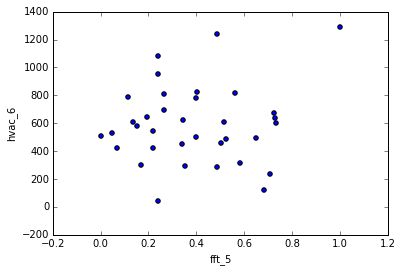

In [22]:
m=6
wm = 'hvac_%d' %m
feature_plot="fft_5"
df.ix[all_homes["hvac"]][[feature_plot,wm]].plot(kind="scatter", x=feature_plot,y=wm)
df.ix[all_homes["hvac"]][[feature_plot,wm]].corr()

In [133]:
temp = create_predictions('wm',['area'],1)
errors = {}
for i in range(1, 13):
    errors[i] = percentage_error(temp[i]["gt"], temp[i]["pred"])
error_df = pd.DataFrame(errors)
accur_df = 100-error_df
accur_df[accur_df<0]=0

In [136]:
accur_df.dropna().median()

1     75.396849
2     54.210730
3     70.017919
4     76.092595
5     67.051359
6     72.371640
7     61.919578
8     52.771398
9     49.699680
10    49.753408
11    51.554367
12    57.104109
dtype: float64

In [272]:
all_homes['dw']

array([  94,  370,  545,  624, 1642, 2156, 2242, 2470, 2814, 2829, 3367,
       3456, 3723, 3967, 4767, 5357, 6072, 6636, 6910, 7769, 7850, 9922,
       9934])

In [318]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")
out_dw = {}
for home in all_homes['dw']:
    a = st['/%d' %home]['2013']['dishwasher1'].resample("15T")
    print home
    out_dw[home] = {'bet_500_1000':len(a.diff().abs()[(a.diff().abs()>500) & (a.diff().abs()<1000)]),
                    'gt_1000':len(a.diff().abs()[(a.diff().abs()>1000)])}

94
370
545
624
1642
2156
2242
2470
2814
2829
3367
3456
3723
3967
4767
5357
6072
6636
6910
7769
7850
9922
9934


In [313]:
df.ix[all_homes['dw']].bet_500_1000

94      0.114616
370     0.108364
545     0.168227
624     0.135370
1642    0.116700
2156    0.136198
2242    0.120325
2470    0.094376
2814    0.102279
2829    0.065801
3367    0.134742
3456    0.129175
3723    0.119355
3967    0.105681
4767    0.147731
5357    0.180274
6072    0.088638
6636    0.026292
6910    0.053754
7769    0.070911
7850    0.075657
9922    0.090751
9934    0.208136
Name: bet_500_1000, dtype: float64

In [319]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.scatter(pd.Series(out_dw), df.ix[all_homes['dw']].bet_500_1000)
#.corr(df.ix[all_homes['dw']].bet_500_1000)

TypeError: float() argument must be a string or a number

TypeError: float() argument must be a string or a number

In [339]:
pd.Series(out_dw['bet_500_1000']).corr(df.ix[all_homes['dw']].bet_500_1000)

KeyError: 'bet_500_1000'

In [340]:
pd.DataFrame(out_dw).T.corrwith(df.ix[all_homes['dw']].bet_500_1000)

bet_500_1000    0.631211
gt_1000         0.273902
dtype: float64

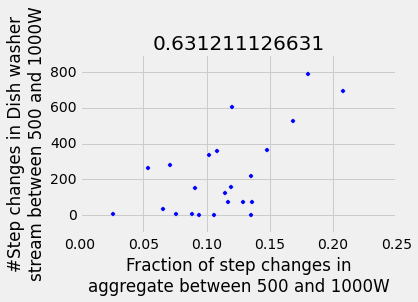

In [350]:
plt.scatter(df.ix[all_homes['dw']].bet_500_1000, pd.DataFrame(out_dw).T['bet_500_1000'])
plt.xlabel("Fraction of step changes in \naggregate between 500 and 1000W")
plt.ylabel("#Step changes in Dish washer \nstream between 500 and 1000W")
plt.title(df.ix[all_homes['dw']].bet_500_1000.corr(pd.DataFrame(out_dw).T['bet_500_1000']))
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/figures/new/dw_aggregate_step_changes.png")

In [338]:
df.ix[all_homes['dw']]['dw_5']

94       4.389723
370     26.143587
545     18.027090
624     20.888189
1642     0.000000
2156     3.560072
2242    19.654873
2470     0.012189
2814    11.864521
2829     7.631028
3367     0.244341
3456     0.835023
3723    35.810143
3967     0.048807
4767     9.052568
5357    16.497515
6072     0.008568
6636     1.574064
6910    13.312785
7769     6.195429
7850     0.000000
9922     0.722194
9934    41.853798
Name: dw_5, dtype: float64